# 💾 UCI Adult Dataset - Machine Learning Project


## Introduction

This machine learning project, conducted under the guidance of Professor Matteo Zignani from Università degli Studi di Milano, focuses on a supervised binary classification task using the Adult dataset. The dataset, originally from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult) is typically provided pre-split into training and test sets. To simulate and have greater control over the data splitting process, I used a [version of the dataset available on Kaggle](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset), which provides the data in a single, unsplit format. This approach allowed me to perform my own train-test split.

The goal of the project is to classify whether an individual earns more than $50,000 per year by leveraging preprocessing techniques and classification models to uncover patterns and relationships within the data, ultimately building an accurate predictive model.

ChatGPT was used as a supplementary tool to clarify concepts and assist with some implementation questions during the project.

### Imports

In [1]:
# Base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.compose import ColumnTransformer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.stats import uniform
from scipy.stats import loguniform, uniform

### Utils

Originally, I had all of the custom functions, constants and model configurations as separate files under a folder called `utils`. However, given the deliverable is only the Jupyter Notebook file, I had to move them all here, so I will dedicate this section to define them all.

#### Custom Functions

In [2]:
def plot_learning_curve(
    estimator, X, y, ax, title="Learning Curve", cv=5, scoring="f1"
):
    """
    Plots a learning curve.

    Parameters:
        estimator: The model to evaluate.
        X: Feature set.
        y: Target labels.
        ax: Matplotlib axis to plot on.
        title: Title for the plot.
        cv: Number of cross-validation folds.
        scoring: Scoring metric for evaluation.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], cv=cv, scoring=scoring
    )

    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    # Plot learning curve
    ax.plot(train_sizes, train_mean, label="Training Score", color="blue")
    ax.plot(train_sizes, test_mean, label="Testing Score", color="orange")

    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel("F1 Score")
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)


def plot_roc_auc(y_test, y_prob, title="ROC Curve", ax=None):
    """
    Plots the ROC Curve and displays the AUC score.

    Parameters:
        y_test: Array-like, true labels for the test set.
        y_prob: Array-like, predicted probabilities for the positive class.
        title: Title for the plot.
        ax: Matplotlib axis to plot on (optional).
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    if ax is None:
        ax = plt.gca()  # Use the current axis if none is provided
    ax.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)


def plot_precision_recall(y_test, y_prob, title="Precision-Recall Curve", ax=None):
    """
    Plots the Precision-Recall Curve and displays the AUC-PR score, along with a bisector line (m = -1).

    Parameters:
        y_test: Array-like, true labels for the test set.
        y_prob: Array-like, predicted probabilities for the positive class.
        title: Title for the plot.
        ax: Matplotlib axis to plot on (optional).
    """
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auc_pr = auc(recall, precision)  # Calculate AUC-PR

    if ax is None:
        ax = plt.gca()  # Use the current axis if none is provided
    ax.plot(recall, precision, label=f"AUC = {auc_pr:.2f}")
    ax.plot([0, 1], [1, 0], linestyle="--", color="gray")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.legend(loc="lower left")
    ax.grid(alpha=0.3)


def plot_validation_curve(
    estimator,
    X,
    y,
    param_name,
    param_range,
    cv,
    scoring,
    ax=None,
    title="Validation Curve",
):
    """
    Plots the validation curve for a given estimator and hyperparameter on a specified axis.

    Parameters:
        estimator: The model to evaluate (e.g., GradientBoostingClassifier).
        X: Training data (features).
        y: Training data (labels).
        param_name: Name of the hyperparameter to vary (e.g., "n_estimators").
        param_range: Range of values for the hyperparameter.
        cv: Cross-validation splitting strategy.
        scoring: Scoring metric to evaluate the model (e.g., "f1").
        ax: Matplotlib axis to plot on (optional).
        title: Title for the plot.
    """
    train_scores, test_scores = validation_curve(
        estimator,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
    )

    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Use provided axis or create one
    if ax is None:
        ax = plt.gca()

    # Plot the validation curve
    ax.plot(param_range, train_mean, label="Training Score", color="blue")
    ax.plot(param_range, test_mean, label="Validation Score", color="orange")
    ax.fill_between(
        param_range,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.2,
        color="blue",
    )
    ax.fill_between(
        param_range,
        test_mean - test_std,
        test_mean + test_std,
        alpha=0.2,
        color="orange",
    )

    # Add labels, title, and legend
    ax.set_title(title)
    ax.set_xlabel(param_name)
    ax.set_ylabel(scoring)
    ax.legend(loc="best")
    ax.grid(alpha=0.3)


def plot_category_target_count(df, column_name, target_column='income', target_value='>50K'):
    """
    Plots the count of rows for each category in a given column where the target equals the target_value.
    Basically to understand which values for each feature are more likely to be associated with the target value being >50k
    
    Parameters:
    - df: pandas DataFrame
    - column_name: The name of the column to analyze (categorical feature).
    - target_column: The name of the target column.
    - target_value: The target value to filter on (default is 1).
    """
    if column_name not in df.columns:
        print(f"Column '{column_name}' does not exist in the dataset.")
        return

    # Filter rows where target equals the target_value
    filtered_df = df[df[target_column] == target_value]
    
    # Group by the column and count rows, then sort by the index (x-axis)
    category_counts = (
        filtered_df.groupby(column_name)
        .size()
        .sort_index()  # Sort by index 
    )
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind="bar", color="cornflowerblue")
    plt.title(f"Count of Rows by {column_name} where {target_column} = {target_value}")
    plt.ylabel("Count of Rows")
    plt.xlabel(column_name)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

#### Constants

In [3]:
country_mapping = mapping = {
    # North America
    "United-States": "North America",
    "Canada": "North America",
    "Mexico": "North America",
    "Puerto-Rico": "North America",
    "Cuba": "North America",
    "Jamaica": "North America",
    "Dominican-Republic": "North America",
    "Honduras": "North America",
    "Guatemala": "North America",
    "El-Salvador": "North America",
    "Nicaragua": "North America",
    "Haiti": "North America",
    # Europe
    "England": "Europe",
    "Germany": "Europe",
    "Italy": "Europe",
    "Poland": "Europe",
    "Portugal": "Europe",
    "France": "Europe",
    "Ireland": "Europe",
    "Scotland": "Europe",
    # Asia
    "Philippines": "Asia",
    "India": "Asia",
    "China": "Asia",
    "Vietnam": "Asia",
    "Japan": "Asia",
    "Iran": "Asia",
    "Taiwan": "Asia",
    "Hong": "Asia",
    "Thailand": "Asia",
    "Laos": "Asia",
    # South America
    "Columbia": "South America",
    "Ecuador": "South America",
    "Peru": "South America",
    "South": "South America",
    "Brazil": "South America",
    # Other
    "Other": "Other",
}

#### Configurations

In [4]:
# Sampler configurations
sampler_configs = [
    {"sampler": [None]},
    # The floats in the strategies are the ratios of the minority class over the majority class
    {
        "sampler": [SMOTE()],  # KNN for oversampling
        "sampler__sampling_strategy": [0.5, 0.8, 1.0],
    },
    {
        "sampler": [RandomOverSampler()],  # Random oversampling by duplicating existing
        "sampler__sampling_strategy": [0.5, 0.8, 1.0],
    },
]

# Dimensionality reduction configurations
dim_reduction_configs = [
    {"dim_reduction": [None]},  # Bypass dimensionality reduction
    # Since 0 < n_components < 1, it represents the variance (deviation from the mean) for PCA
    {"dim_reduction": [PCA()], "dim_reduction__n_components": [0.5, 0.8, 0.9]},
    # {"dim_reduction": [LDA()]},  # LDA is not compatible with the dataset (negative values when scaled)
    {
        # SFS starts with empty set of features and adds one by one
        # At each step it trains the model with the rest of the features and selects the best
        "dim_reduction": [SFS(estimator=Perceptron(), cv=None, scoring="f1")],
        "dim_reduction__estimator": [Perceptron(), LogisticRegression()],
        "dim_reduction__k_features": [3, 7, 15],  # Number of features to maintain
    },
]

# Classifier configurations
classifier_configs = [
    {
        "classifier": [Perceptron()],
        "classifier__max_iter": [100, 200],
        # loguniform is used to sample mostly small values but also a few large values
        # This is useful for hyperparameters that are usually small but can be large
        "classifier__eta0": loguniform(0.001, 10),
        # Handles potential class imbalances through weights
        "classifier__class_weight": [None, "balanced"],
    },
    {
        "classifier": [LogisticRegression(solver="lbfgs")],
        "classifier__max_iter": [700, 750],
        "classifier__C": uniform(1, 10),
        "classifier__penalty": ["l2"],  # Only L2 for lbfgs
        "classifier__class_weight": [None, "balanced"],
    },
    {
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": [
            10,
            30,
            45,
            75,
        ],
        "classifier__weights": ["uniform", "distance"],

    },
    {
        # This model outperforms the rest, it also takes a lot of time on the cv making the development of the project very slow.
        "classifier": [GradientBoostingClassifier(warm_start=True)],
        "classifier__n_estimators": [300],  # Number of trees
        "classifier__max_depth": [5],  # Maximum depth of each tree
    },
]

## Analyze the data

Let's load the dataset into a Pandas dataframe and look more into detail the different columns we have.

In [5]:
df = pd.read_csv("../data/adult.csv", header=0, skipinitialspace=True, na_values="?")
df.shape # (rows, columns)

(48842, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


We can see that some columns have null values, let's look into more detail which ones and how many.

In [7]:
df.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

We will need to deal with missing values for the columns `workclass`, `occupation` and `native-country`.


In [8]:
# Look at some sample rows
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


Let's use the method `value_counts` to analyze each feature with more detail.

In [9]:
# Change 'occupation' for any other feature you'd like to inspect.
print(df['occupation'].value_counts())

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64


This plot provides a clear visualization of how positive target values (income > $50K) are distributed across the categories of a selected feature (e.g., occupation). You can easily replace `occupation` with any other categorical feature to explore different aspects of the data. Additionally, you can delve deeper into feature relationships by specifying different second and third parameters. For example, using `plot_category_target_count(df, "race", "relationship", "husband")` reveals the number of individuals from each race who are classified as husbands.

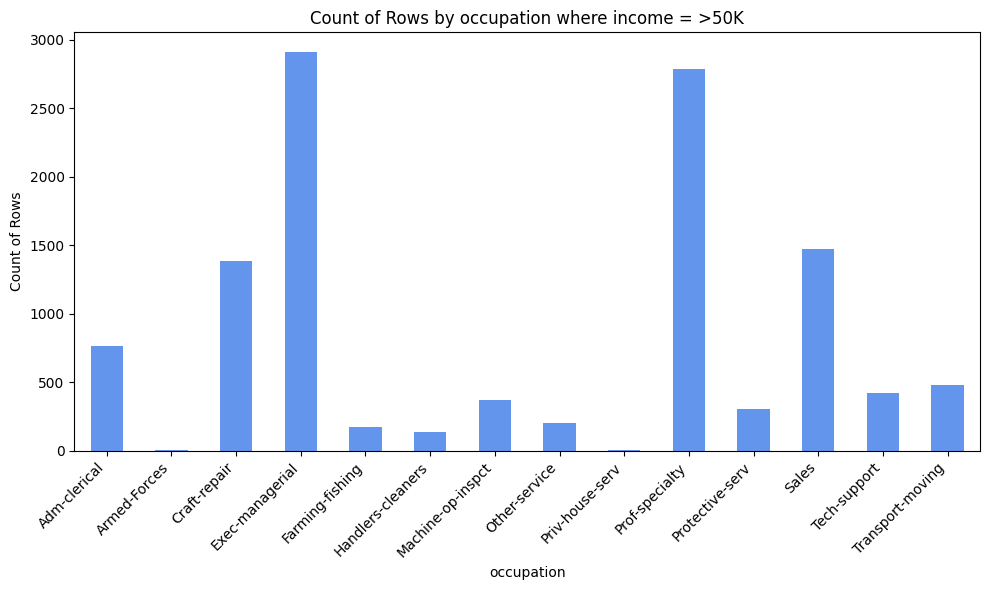

In [10]:
plot_category_target_count(df, "occupation")

## Definition of the Data Transformation Pipeline

Here we have a schema of the data transformation pipeline that we want to create. The columns that are not present are going to be dropped.

![Data transformatino Pipeline](./images/data-transformation-pipeline.jpg)

We drop `education`, since it represents the same as `educational-num` and we also drop `fnlwgt` since it is a feature with no description, and we have no understanding of what it is, it could pottentially contain the target encoded (income).

In this project, we utilize four custom transformers to handle specific feature engineering tasks. These transformers ensure that our preprocessing pipeline remains clean, modular, reusable and custom for each feature.

Below is an explanation of each custom transformer and their purpose along with the feature pipeline for it.

### Custom Transformers in the Project

#### 1. `MaritalStatusBinarizer`

Converts the **marital-status** feature into a binary feature (1 for married, 0 for not married) to simplify analysis and modeling.

In [11]:
def binarize_marital_status(X):
    mapping = {
        'Married-civ-spouse': 1,
        'Married-spouse-absent': 1,
        'Married-AF-spouse': 1,
        'Never-married': 0,
        'Divorced': 0,
        'Separated': 0,
        'Widowed': 0
    }

    X = X.values.ravel() # ravel is used to go from (n_samples, 1) to (n_samples, ) and iterating through it is easier.

    return np.array([[mapping.get(value, 0)] for value in X])

# Pipeline for Marital Status
pipeline_marital_status = Pipeline([
    ('marital-status-binarizer', FunctionTransformer(binarize_marital_status, # Such an easy transformation can be done with FunctionTrasnformer
    validate=False,
))
])


#### 2. `CombineCapitalFeatures`

Combines the **capital-gain** and **capital-loss** features into a single **net-capital** feature.

In [12]:
class CombineCapitalFeatures(BaseEstimator, TransformerMixin):
    # Inheriting from TransformerMixin provides (among other things) a default implementation of fit_transform so we need to define both methods fit and trasnform.
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convert X into a NumPy array
        X = np.asarray(X)
        # Now X is a list of lists with two elements, e.g:
        #[
        #  [capital-gain1, capital-loss1],
        #  [capital-gain2, capital-loss2],
        #  ...
        #]

        # Compute net-capital (difference between gain and loss)
        net_capital = X[:, 0] - X[:, 1]
        # The syntax X[row_index, column_index] (or X[start:end, start:end] for slicing) is designed for matrix-style operations:
        # X[:, 0] means "all rows, first column"
        
        # scikit-learn expects input and output arrays to be 2D
        return net_capital.reshape(-1, 1) 
        #(-1, 1):
        # The -1 means "figure out the correct number of rows based on the size of the array."
        # The 1 specifies that there should be exactly 1 column.

# Pipeline for combining and scaling capital features
pipeline_capital_features = Pipeline([
    ('combine_capital', CombineCapitalFeatures()),
    ('scaler', StandardScaler()), # I plotted this feature and it follows approximately a normal distribution so StandardScaler makes sense to use.
])

#### 3. `HoursBinner`

Bins the **hours-per-week** feature into categories: Part-time, Full-time, and Overtime.

In [13]:
class HoursBinner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.Series(X.values.ravel()) # A Series is one column of a Dataframe
        
        # Define bins and labels
        bins = [0, 30, 50, float('inf')]  # Inf handles any hours > 50
        labels = ['Part-time', 'Full-time', 'Overtime']
        # bins length is bigger than labels because it defined bounds for the intervals
        # 0 < Part-time ≤ 30
        # ≤30 because right=False

        # Apply binning
        binned = pd.cut(X, bins=bins, labels=labels, right=False)
        
        # Return as a 2D array
        return np.array(binned).reshape(-1, 1)

# Pipeline for Hours Binning
pipeline_hours_binner = Pipeline([
    ('binning', HoursBinner()),
    ('onehot', OneHotEncoder())
])


#### 4. `CountryGrouper`

Groups the **native-country** feature into broader regions (e.g., North America, Europe) to reduce the number of categories and simplify the model.

In [14]:
class CountryGrouper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Flatten X to a 1D array for processing
        X_flat = np.ravel(X)

        # Apply mapping with a default value of "Other" for unknown countries
        grouped = [country_mapping.get(country, 'Other') for country in X_flat]
 
        # Return as a 2D array
        return np.array(grouped).reshape(-1, 1)

# Pipeline for Country Grouping and Encoding
pipeline_country = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('group', CountryGrouper()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### Column Transformer

We finish by creating the pipelines for the remaining features that have more than one transformation and defining the Column Transformer for **all** the features.

In [15]:
# Pipelines for the remaning features
pipeline_workclass_occupation = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all pipelines in a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('scaler', MinMaxScaler(), ['age', 'educational-num']),
    ('workclass_occupation', pipeline_workclass_occupation, ['workclass', 'occupation']),
    ('marital_status', pipeline_marital_status, ['marital-status']),
    ('relationship_and_race', OneHotEncoder(handle_unknown='ignore'), ['relationship', 'race']),
    ('gender', OneHotEncoder(drop="if_binary"), ['gender']),
    ('capital', pipeline_capital_features, ['capital-gain', 'capital-loss']),
    ('hours_per_week', pipeline_hours_binner, ['hours-per-week']),
    ('native_country', pipeline_country, ['native-country']),
],
remainder='drop',
verbose_feature_names_out=False, # This is to avoid the verbose names that the ColumnTransformer generates
sparse_threshold=0) # Dense matrices instead of sparse (KNN, PCA, etc. don't work with sparse matrices)

## Training and test split

Now, we can split the entire dataset into training and test sets, putting 20% of the instances in the test set. I will then binarize the income column into 0/1 values for clarity and compatibility.

In [16]:
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y Ensures that the class distribution in y is preserved in both the training and testing splits.

lb = LabelBinarizer()
# Because of lexicographical order, we will have 0 for <=50K and 1 for >50K
y_train = lb.fit_transform(y_train_orig).ravel()
y_test = lb.transform(y_test_orig).ravel()

## Model example with KNN

Before delving into cross-validation, this section provides an illustrative example of how a single machine learning model can be trained, tested, and evaluated using the K-Nearest Neighbors (KNN) algorithm.

The following steps outline the process performed in the subsequent code cell:
1. **Apply Fitting and Transformation**: Preprocess the input features `X` by applying necessary transformations to prepare the data for model training.

2. **Create and Fit the Model**: Instantiate a KNN model and train it on the transformed training data. During this step, the hyperparameter `n_neighbors` can be tuned to observe its impact on performance later.

3. **Make Predictions**: Use the trained model to predict the target variable for both the training and test datasets.

4. **Evaluate Performance**: Measure the model's precission, recall and F1 score to assess its performance on both the training and test sets.

5. **Analyze Performance**: Delve deeper into the model's performance by visualizing results using metrics like the confusion matrix, learning curve, ROC curve, and AUC score.

Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     29724
           1       0.74      0.60      0.66      9349

    accuracy                           0.85     39073
   macro avg       0.81      0.77      0.78     39073
weighted avg       0.85      0.85      0.85     39073

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      7431
           1       0.74      0.59      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.85      0.85      0.85      9769



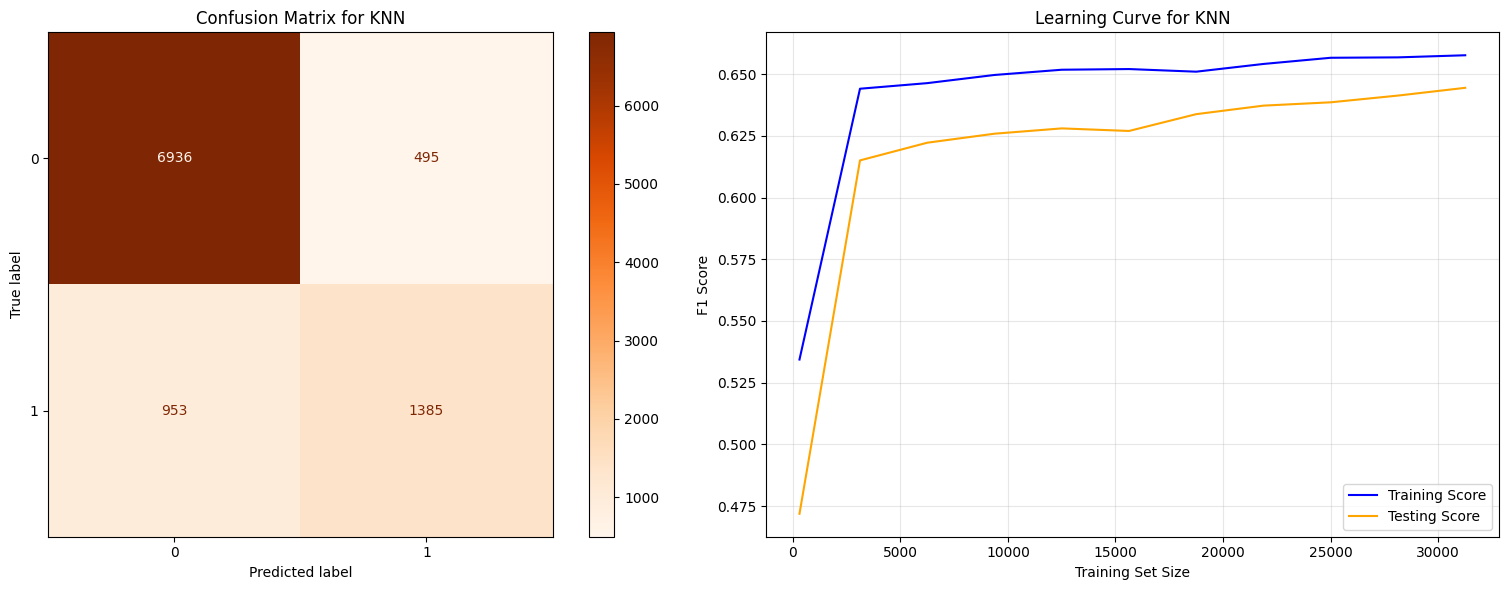

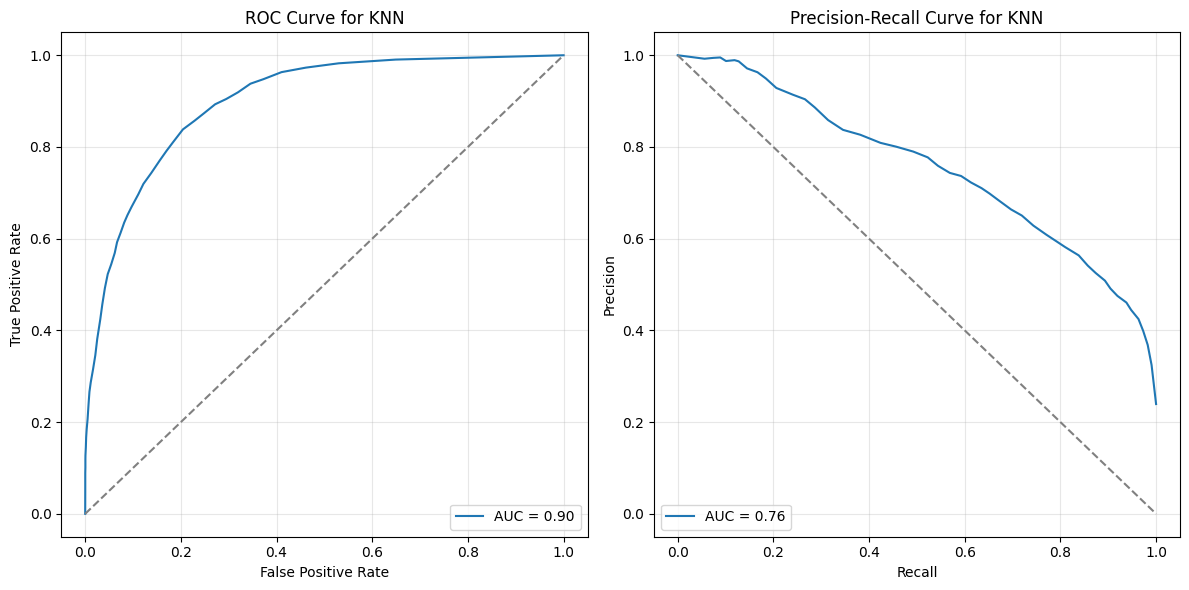

In [17]:
# 1) Preprocessing
X_train_knn = preprocessor.fit_transform(X_train)
X_test_knn = preprocessor.transform(X_test)

# 2) Create and fit the K-Nearest Neighbors model
model_knn = KNeighborsClassifier(n_neighbors=45)  # You can adjust `n_neighbors` to optimize performance
model_knn.fit(X_train_knn, y_train)

# 3) Make predictions on the training and test set
y_train_pred_knn = model_knn.predict(X_train_knn)
y_test_pred_knn = model_knn.predict(X_test_knn)

# 4) Evaluate the performance on training and test data
print("Classification Report (Train Data):")
print(classification_report(y_train, y_train_pred_knn))
print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_knn))

# 5) Analyze Performance
# Assuming you have y_test and y_prob already
y_prob = model_knn.predict_proba(X_test_knn)[:, 1]  # Predicted probabilities for class 1
# KNN is not inherently a probabilistic model, but it can still output probabilities using neighbor voting.
# scikit-learn estimates the probability of a sample belonging to each class based on the proportion of neighbors in that class.

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot Confusion Matrix on the left
ConfusionMatrixDisplay.from_estimator(model_knn, X_test_knn, y_test, cmap=plt.cm.Oranges, ax=axes[0])
axes[0].set_title("Confusion Matrix for KNN")

# Plot Learning Curve on the right
plot_learning_curve(model_knn, X_train_knn, y_train, ax=axes[1], title="Learning Curve for KNN")

# Adjust layout and show
plt.tight_layout()
plt.show()

# Create a figure with subplots for inline plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot ROC Curve on the first axis
plt.sca(axes[0])  # Set current axis for the ROC plot
plot_roc_auc(y_test, y_prob, title="ROC Curve for KNN")

# Plot Precision-Recall Curve on the second axis
plt.sca(axes[1])  # Set current axis for the Precision-Recall plot
plot_precision_recall(y_test, y_prob, title="Precision-Recall Curve for KNN")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Model Selection with Nested Cross-Validation


This section focuses on selecting the best model and hyperparameters using **nested cross-validation**. By combining an *inner loop* for hyperparameter optimization and an *outer loop* for performance evaluation, this approach ensures a fair assessment of the model's generalization ability.

### Define possible configurations

We define the base pipeline by using the KNN example model created before and its configurations. We are using `IMBPipeline` because it extends the scikit-learn pipeline with the ability to incorporate samplers for balancing classes.

In [18]:
# Define the base pipeline
model_pipeline = IMBPipeline([  #IMB(alanced) pipeline allow us to add sampler configs
    ('preprocessing', preprocessor),
    ('sampler', None),
    ('dim_reduction', None),
    ('classifier', model_knn)
])

I defined the possible configurations under the `utils` section in the introduction for clarity and to keep the notebook clean, in this code cell we use itertools to form all the possible combinations of the different configurations defined before.

In [19]:
# Combine all possible configurations
all_configs = [
    dict(itertools.chain(*(config.items() for config in combination)))  # Unpack all configurations into a single dictionary
    for combination in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs) # Cartesian product of all configurations
]

print(f"Number of configurations: {len(all_configs)}")

Number of configurations: 36


### Execute the nested cross validation

The `cross_validate` function from scikit-learn performs the outer cross-validation by splitting the dataset into 5 folds. For each fold, it passes the training data for that outer fold to RandomizedSearchCV.

RandomizedSearchCV then performs its inner 2-fold cross-validation on the training data from the outer fold, testing different hyperparameter combinations and selecting the best ones for that specific outer fold.

Finally, the model with the best hyperparameters (determined by the inner loop) is evaluated on the test data for the current outer fold, and the results are stored.

In [20]:

# Inner loop definition: RandomizedSearchCV with cv=2 which means 2-fold cross-validation
rs = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    cv=2,
    scoring='f1',
)

In [ ]:
# Define StratifiedKFold with 5 splits
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Outer loop with cross-validation (~30mins)
scores = cross_validate(
    rs,
    X_train,
    y_train,
    scoring='f1',
    cv=stratified_cv,
    return_estimator=True,
    verbose=3,
)

[CV] END ......................................., score=0.728 total time= 6.5min


We print the result for each fold:

In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print('Classifier used: ', estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print('Sampler used: ', estimator.best_estimator_.get_params()['sampler'])
    print('Dimensionality reduction used: ', estimator.best_estimator_.get_params()['dim_reduction'])
    print('Score obtained (F1): ', scores['test_score'][index])
    print('-'*50)

Classifier used:  GradientBoostingClassifier(max_depth=5, n_estimators=300) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Sampler used:  RandomOverSampler(sampling_strategy=0.5)
Dimensionality reduction used:  None
Score obtained:  0.735140771637122
--------------------------------------------------
Classifier used:  GradientBoostingClassifier(max_depth=5, n_estimators=300) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samp

To further reduce the number of candidates, we re-train the models on the entire training set and evaluate their performance on the test set to select our best candidate

In [160]:
for estimator in scores['estimator']:
    best_model = estimator.best_estimator_.fit(X_train, y_train)
    
    # Make predictions on training and test sets
    pred_train = best_model.predict(X_train)
    pred_test = best_model.predict(X_test)
    
    # Compute F1 scores
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    
    # Print results
    print(f'F1 on training set: {f1_train:.3f}, F1 on test set: {f1_test:.3f}')

F1 on training set: 0.758, F1 on test set: 0.727
F1 on training set: 0.760, F1 on test set: 0.728
F1 on training set: 0.760, F1 on test set: 0.727
F1 on training set: 0.750, F1 on test set: 0.724
F1 on training set: 0.762, F1 on test set: 0.729


### Refinement of the selected model


From the previous step, we have identified one of the best candidate models. In this final step, we refine the hyperparameter optimization by keeping the modeling approach fixed and varying the hyperparameters within a range close to those of the selected "best" model.

In [161]:
# Define the pipeline with the best model configuration
best_model_pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomOverSampler(sampling_strategy=0.5)),  # Include the sampler used in the best model.
    ('classifier', GradientBoostingClassifier()) # Of course the same classifier as well.
    # Dimentionality reduction is None on the best estimator, thus we skip it.
])

params = {
    'classifier__n_estimators': [100, 200, 300],  # Number of trees in the ensemble
    'classifier__max_depth': [3, 5],  # Maximum depth of each tree
}

# Perform RandomizedSearchCV
rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline,
    param_distributions=params,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=1),
    n_iter=5,  # Number of random samples
    scoring='f1',
    n_jobs=-1,
)

# Fit the model
rs_best.fit(X_train, y_train)

# Evaluate on the test set
y_test_pred = rs_best.best_estimator_.predict(X_test)

# Compute metrics
final_f1 = f1_score(y_test, y_test_pred)
final_precision = precision_score(y_test, y_test_pred)
final_accuracy = accuracy_score(y_test, y_test_pred)

# Print results
print(f"Final Accuracy on Test Set: {final_accuracy:.3f}")
print(f"Final Precision on Test Set: {final_precision:.3f}")
print(f"Final F1 Score on Test Set: {final_f1:.3f}")

# Display the best parameters
print("Best Hyperparameters:", rs_best.best_params_)


Final Accuracy on Test Set: 0.868
Final Precision on Test Set: 0.719
Final F1 Score on Test Set: 0.726
Best Hyperparameters: {'classifier__n_estimators': 200, 'classifier__max_depth': 5}


We have found the best model out of our configurations after cross validation and hyperparameter tunning: `Gradient Boosting Classifier` model with 200 trees and max_depth=5.

### Learning and Validation curves

In this section, we will plot two functions to analyze the performance of the Gradient Boosting model. First, we will plot the learning curve to observe how varying the size of the training set impacts the model's performance on both the training and validation data. This will help us understand whether the model is underfitting, overfitting, or well-balanced. Next, we will plot the validation curve to examine how changing the number of trees (`n_estimators`) affects the model's performance, providing insights into the bias-variance trade-off and helping us determine an optimal range for this critical hyperparameter.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocessing
X_train_final = preprocessor.fit_transform(X_train)

# Define the model and cross-validator
model = GradientBoostingClassifier(n_estimators=200, max_depth=5)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# Define the range for the validation curve
param_range = [50, 150, 300]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the learning curve on the first axis
plot_learning_curve(
    estimator=model,
    X=X_train_final,
    y=y_train,
    ax=axes[0],
    title="Learning Curve for Gradient Boosting",
    cv=cv,
)

# Plot the validation curve on the second axis
plot_validation_curve(
    estimator=model,
    X=X_train_final,
    y=y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=cv,
    scoring="f1",
    ax=axes[1],
    title="Validation Curve for Gradient Boosting (n_estimators)"
)

# Show the plots
plt.tight_layout()
plt.show()

### Conclusion

The **learning curve** for Gradient Boosting demonstrates how the model's performance changes with varying training set sizes. The training score (blue line) decreases as the training set size increases, which is expected as the model encounters more diverse data and is less able to perfectly fit all training samples. On the other hand, the cross-validation score (orange line) steadily improves and begins to plateau as the training set size grows, indicating that the model benefits from more data to generalize better. The narrowing gap between the training and cross-validation scores suggests a reduction in overfitting as the dataset size increases, leading to improved model generalization. This analysis highlights the importance of using a sufficiently large training set to balance bias and variance in the model's performance.

The **validation curve** illustrates the performance of the Gradient Boosting model as the number of trees (`n_estimators`) increases. The training score (blue line) steadily improves with additional trees, which is expected as the model fits the training data better. Meanwhile, the validation score (orange line) plateaus after approximately 150 trees, indicating diminishing returns in generalization performance. The relatively small gap between the training and validation scores suggests that the model is not overfitting significantly within this range. This analysis indicates that setting n_estimators between 100 and 150 provides a good balance between model complexity and generalization, avoiding unnecessary computational cost from adding too many trees.